# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Первая лабораторная работа </center>


В данной работе Вы познакомитесь с основными методами работы с аудиоданными в Python. Разбересь в том, как работает свертка, и примените пару интересных фильтров.

# Задание 1. Работа с аудиофайлами в Python (1 балл)

## Теория

Звук - это аналоговый сигнал. То есть он является непрерывным по времени и по значениям. Для того, чтобы работать со звуком на цифровом устройстве, надо преобразовать его в цифровое представление. Для этого надо разделить непрерывный сигнал на промежутки времени (дискретизация сигнала) и разбить непрерывные значения на интервалы (квантование сигнала). Выбраные параметры дискретизации и квантования сигнала напрямую влияют на качество цифрового сигнала. 


## Практика

In [1]:
import wave
import numpy as np
import scipy
import librosa

import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
filepath = 'resources/my_music.wav'

> 1. Что хранится в .wav файле? Как узнать параметры дискретизации и квантования .wav файла? 


Модуль wave предназначенный для парсинга wav-файлов. Метод getparams() возвращает кортеж основных параметров файла: число каналов, число байт на сэмпл, число фреймов в секунду, общее число фреймов, тип сжатия, имя типа сжатия. Также в заголовках файла могут содержаться метаданные 

In [3]:
wav = wave.open(filepath, mode="r")
params = wav.getparams()
framerate = params[2]
sampwidth = params[1]
params

_wave_params(nchannels=2, sampwidth=2, framerate=44100, nframes=9287424, comptype='NONE', compname='not compressed')

In [4]:
print(f"Частота дискретизции этой записи - {framerate}")

Частота дискретизции этой записи - 44100


Параметр sampwidth разрядность кварнования в байтах:
* 1 = 8 бит, беззнаковое целое (0-255),
* 2 = 16 бит, знаковое целое (-32768-32767)
* 4 = 32 бит, знаковое длинное целое (-2147483648-2147483647)

In [5]:
print(f"Разрядность квантования этой записи - {sampwidth * 8} бит") 

Разрядность квантования этой записи - 16 бит


> 2. Запишите аудиофайл со своим голосом. Загрузите его. Попробуйте поменять ему частоту дискретизации. Нарисуйте форму волны считанного файла. Воспроизведите полученные сигналы. При какой частоте дискретизации становится невозможно разобрать человеческую речь?   

In [6]:
def waveplot(y, sr):
    fig, ax = plt.subplots(sharex=True, sharey=True)
    fig.set_size_inches(21, 4)
    librosa.display.waveplot(y, sr=sr, ax=ax)

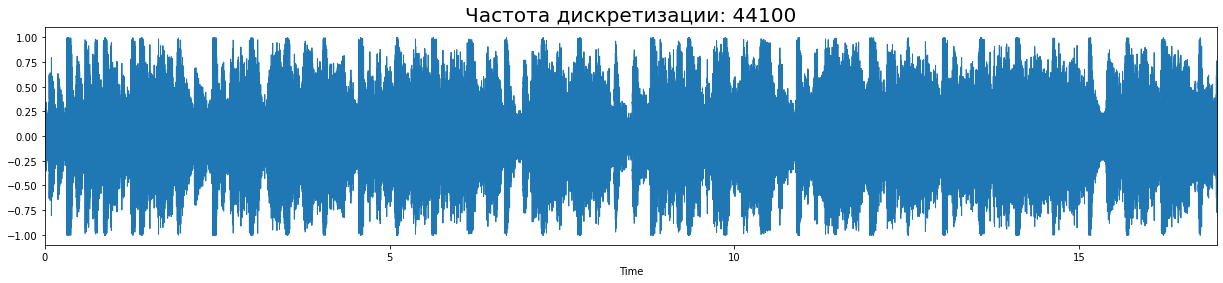

In [7]:
y, sr_original = librosa.load(filepath, duration=17, offset=43, sr=44100)
waveplot(y, sr_original)
plt.title(f'Частота дискретизации: {sr_original}', fontsize=20)
ipd.Audio(y, rate=sr_original)

/home/markh/anaconda3/lib/python3.8/site-packages/librosa/util/utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


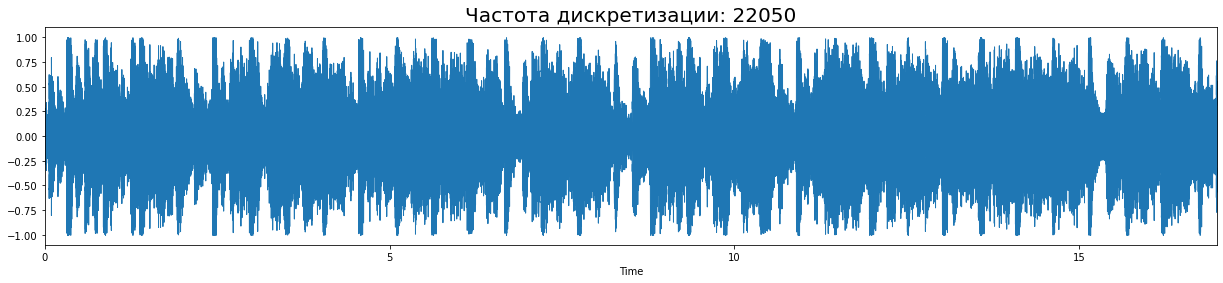

In [8]:
sr = int(sr_original / 2)
waveplot(y[::2], sr)
plt.title(f'Частота дискретизации: {sr}', fontsize=20)
ipd.Audio(y[::2], rate=sr)

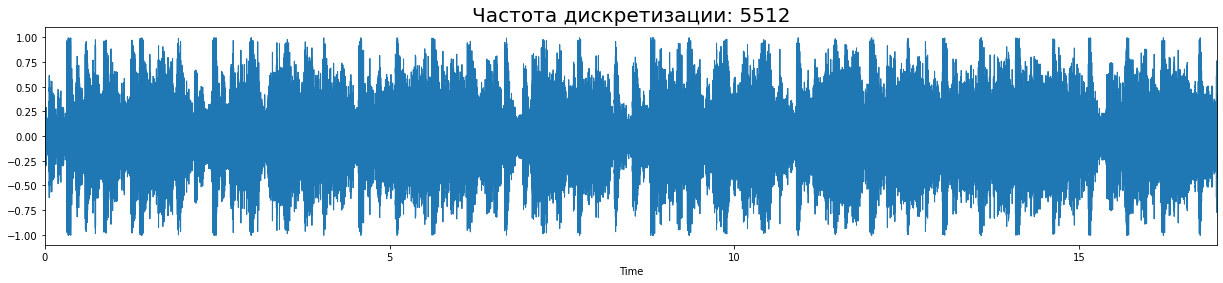

In [9]:
sr = int(sr_original / 8)
waveplot(y[::8], sr)
plt.title(f'Частота дискретизации: {sr}', fontsize=20)
ipd.Audio(y[::8], rate=sr)

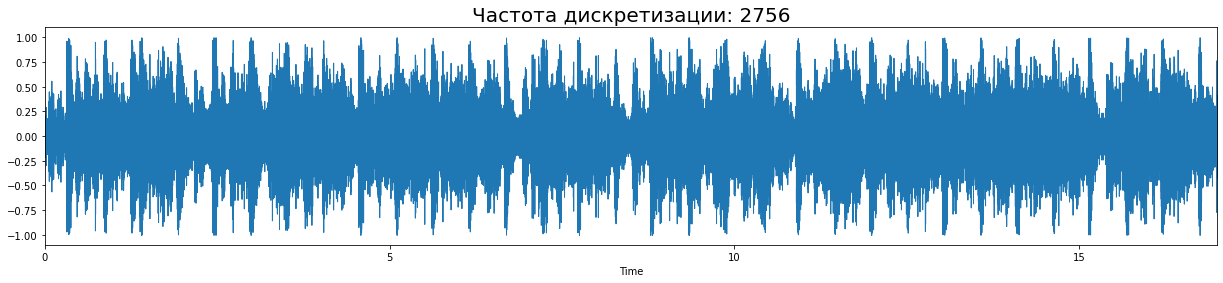

In [10]:
sr = int(sr_original / 16)
waveplot(y[::16], sr)
plt.title(f'Частота дискретизации: {sr}', fontsize=20)
ipd.Audio(y[::16], rate=sr)

Изначально частота была 44100. При частоте в 16 раз меньше (2756 Гц) уже сложно понимать речь

> 3. Чем .wav отличается от других кодеков, например .mp3 или .ogg?

Основное различие .wav формата от .mp3 или .ogg - это то, что .wav содержить аудиоданные без сжатия.

# Задание 2. Гармонические сигналы (1 балл)

## Теория
[Гармонические колебания](https://ru.wikipedia.org/wiki/Гармонические_колебания) -  колебания, при которых физическая величина изменяется с течением времени по гармоническому (синусоидальному/косинусоидальному) закону. 

В общем случае гармонические колебания задаются формулой:

$$y=A \cos(\omega t+\varphi_0)$$

где $А$ - это амплитуда, $\omega$ – циклическая частота (радиан/с), $\varphi$ - фаза (сдвиг), $t$ – время. 


In [11]:
def draw_signal(data, figsize=(25, 7)):
    plt.figure(figsize=figsize)
    plt.plot(data, linewidth=2)
    plt.minorticks_on()
    plt.xticks(np.arange(0, 1000, step=100))
    plt.yticks(np.arange((data.min().round())//10*10, 
                         (data.max().round())//10*10+10, step=5))
    plt.grid(which='major',
        color = 'k', 
        linewidth = 1)
    plt.grid(which='minor', 
        color = 'k', 
        linestyle = ':')
    plt.show()

In [12]:
def draw_compare(data_1, data_2, figsize=(25, 14)):
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    for data, i, title in zip([data_1, data_2], [0, 1], ['Origin', 'Handpicked']):
        axes[i].plot(data, linewidth=2)
        axes[i].minorticks_on()
        axes[i].set_xticks(np.arange(0, 1000, step=100))
        axes[i].set_yticks(np.arange((data.min().round())//10*10, 
                             (data.max().round())//10*10+10, step=5))
        axes[i].grid(which='major',
            color = 'k', 
            linewidth = 1)
        axes[i].grid(which='minor', 
            color = 'k', 
            linestyle = ':')
        axes[i].set_title(title, fontsize=20)
    plt.show()

In [13]:
import pickle
with open("resources/data.pickle", "rb") as f:
    test_data = pickle.load(f)

## Практика

Постройте графики трех сигналов a, b и c из test_data['task2']. Попробуйте подобрать коэффициенты для этих сигналов. Сгенерируйте сигналы (1000 отсчетов) с подобранными коэффициентами. Постройте графики сгенерированных сигналов и пройдите тест на схожесть с оригинальным.


Подсказка. Фаза, период и амплитуда сигнала - целочисленные. Для генерации пользуйтесь библиотекой numpy и функциями arange, sin, cos.

In [14]:
def signal(A, T, phi, n=1000):
    omega = 2 * np.pi / T
    t = np.arange(0, n)
    return A * np.sin(omega*t + phi)

In [15]:
A = 45
T = 425
phi = np.pi / 2
a = signal(A, T, phi)

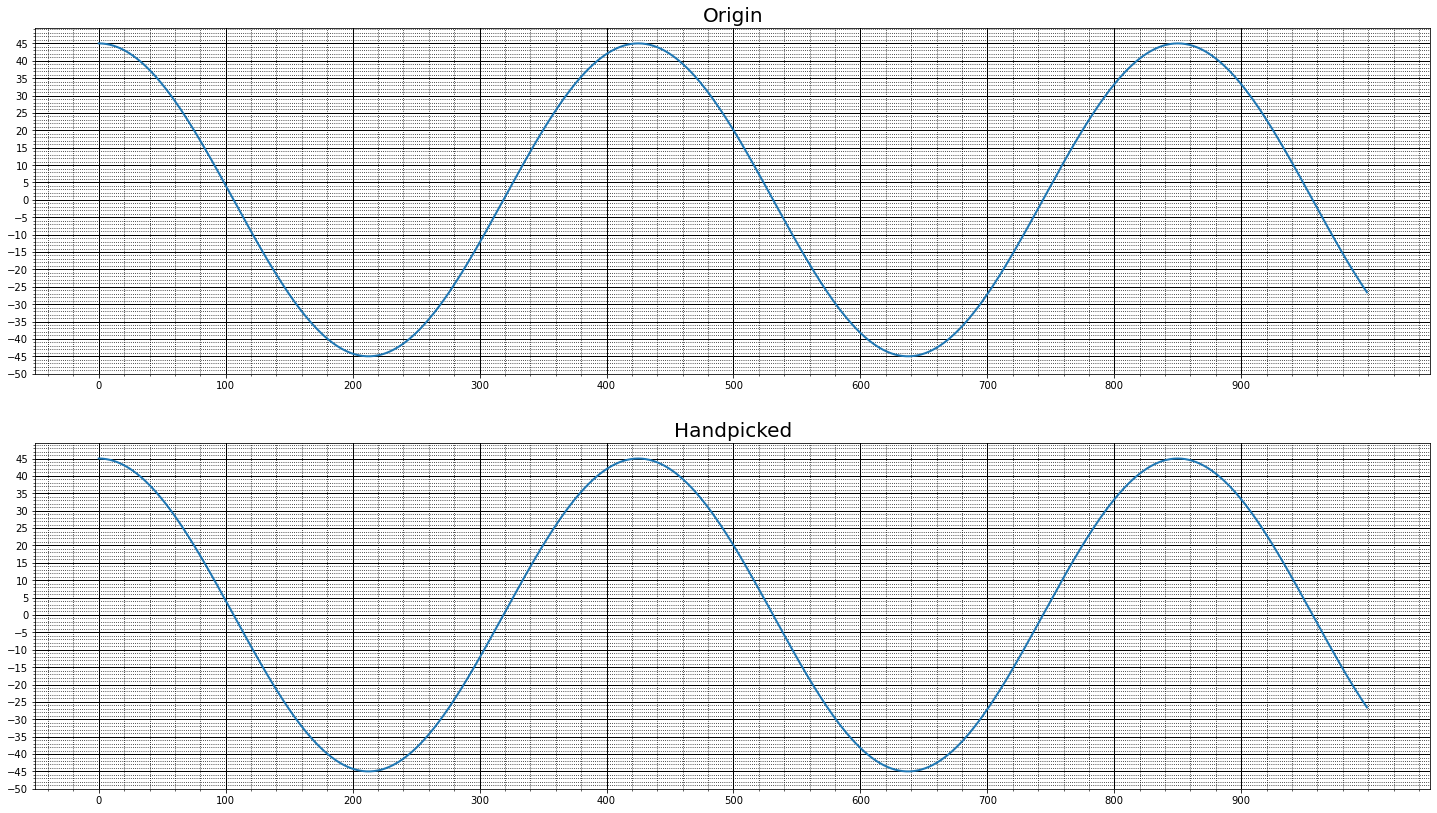

In [16]:
draw_compare(test_data['task2']['a'], a) 

In [17]:
assert len(a) == 1000
assert np.allclose(a, test_data["task2"]["a"], atol=1)
print("Ok!")

Ok!


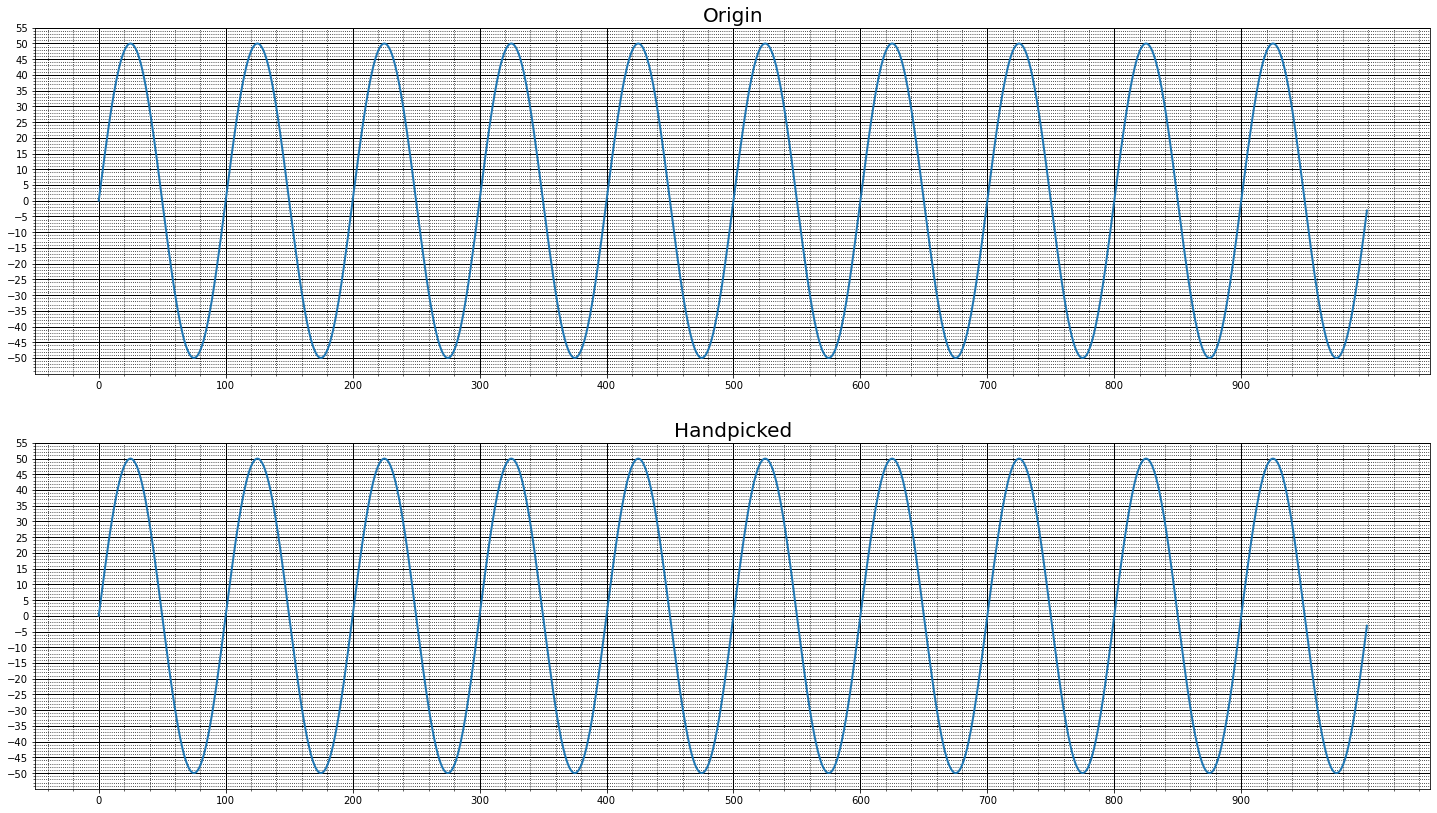

In [18]:
A = 50
T = 100
phi = 0 
b = signal(A, T, phi)
draw_compare(test_data['task2']['b'], b) 

In [19]:
assert len(b)== 1000
assert np.allclose(b, test_data["task2"]["b"], atol=1)
print("Ok!")

Ok!


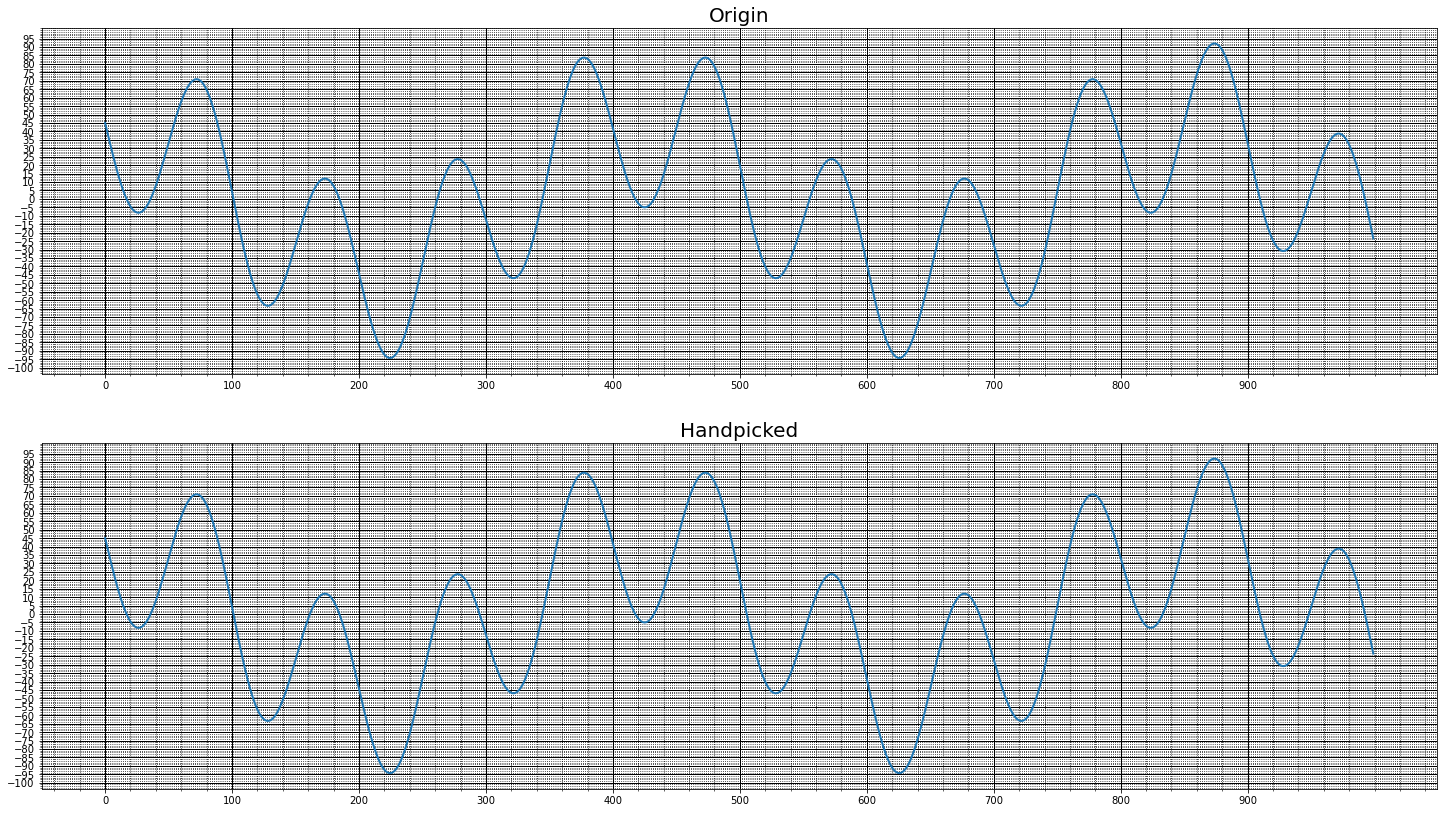

In [20]:
A_1 = 45
T_1 = 425
phi_1 = np.pi / 2

A_2 = -50
T_2 = 100
phi_2 = 0 #np.pi / 4

c = signal(A_1, T_1, phi_1) + signal(A_2, T_2, phi_2)
draw_compare(test_data['task2']['c'], c) 

In [21]:
assert len(c)== 1000
assert np.allclose(c, test_data["task2"]["c"], atol=1)
print("Ok!")

Ok!


# Задание 3. Свертка (3 балла)

## Теория
Одна из наиболее частых операций, которая выполняется при обработке сигналов, это свёртка. Свёртка имеет много различных применений, например, с ее помощью можно убрать из сигнала шумы или применить к сигналу эффект эхо.


Свёртка — это математическая операция, применённая к двум функциям f и g и порождающая третью функцию. Операцию свёртки можно интерпретировать как «схожесть» одной функции с отражённой и сдвинутой копией другой.  Другими словами, преобразование свёртки однозначно определяет выходной сигнал y(t) для установленного значения входного сигнала x(t) при известном значении функции импульсного отклика системы h(t).

![Convolution](resources/Convolution_of_box_signal_with_itself2.gif "Convolution")

Формула свёртки:
$$y_t=\frac{1}{2} \int_0^T x(\tau)h(t-τ)dτ$$
где $\tau$  - длительность импульсной переходной характеристики.

## Практика
Реализуйте операцию свёртки. Сравните её с существующей реализацией scipy.signal.convolve. Постройте графики фильтра, исходного сигнала и результата свертки.

In [22]:
def convolve(in1, in2):
    N, M = len(in1), len(in2)
    an = np.concatenate([np.zeros(M - 1, dtype=int), in1])
    bn = np.concatenate([in2[::-1], np.zeros(N - 1, dtype=int)])
    return np.array([np.sum(an * np.roll(bn, i)) for i in range(N + M - 1)])

In [23]:
def test_convolve(a, b, print_debug=False):
    my_result = convolve(a, b)
    scipy_result = scipy.signal.convolve(a, b, method='direct')
    if print_debug:
        print(f"Your result {my_result}")
        print(f"Scipy result {scipy_result}")
    assert np.allclose(my_result, scipy_result), f"Test {a} conv {b} failed"
    print("Ok!")

In [24]:
a = np.repeat([0, 1, 0], 10)
b = np.array([0, 1, 2, 3, 2, 1, 0])

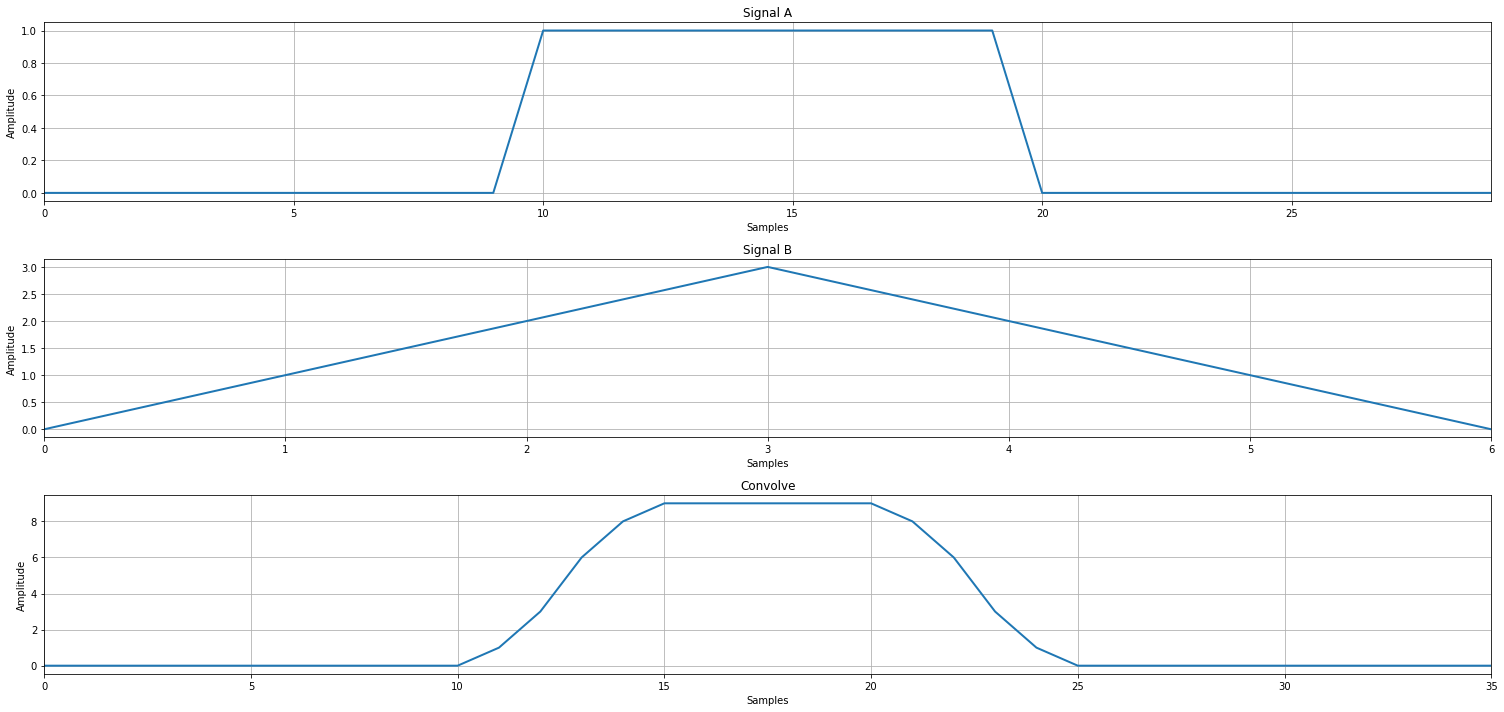

In [25]:
signals = [a, b, convolve(a, b)]
titles = ['Signal A', 'Signal B', 'Convolve']
plt.figure(figsize=(21, 10))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(signals[i], linewidth=2.0)
    plt.title(titles[i])
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.xlim([0, signals[i].size-1])
    plt.grid()
plt.tight_layout()

In [26]:
test_convolve(a, b, print_debug=False)

Ok!


# Задание 4. * Алгоритм Карплуса-Стронга 

Реализуйте  [Алгоритм Карплуса-Стронга](https://en.wikipedia.org/wiki/Karplus%E2%80%93Strong_string_synthesis). В качестве фильтра используйте усреднитель двух смежных отсчетов. Проверьте результат. 

Отрисуйте и воспроизведите полученный сигнал. На что влияют параметры генерации? Попробуйте имитировать звучание разных струн гитары.

In [27]:
def karplus_strong(noise, N):
    samples = np.zeros(int(N))
    for i in range(len(noise)):
        samples[i] = noise[i]
    for i in range(len(noise), len(samples)):
        samples[i] = (samples[i - len(noise)] + samples[i - len(noise) - 1]) / 2
    return samples

In [28]:
np.random.seed(seed=1)
sample_rate = 44100 
frequency = 82.41
sec = 10
gen_len = sample_rate * sec
noise = (2 * np.random.uniform(-1, 1, int(sample_rate / frequency)))

gen_wav = karplus_strong(noise, gen_len)
assert np.allclose(gen_wav[:len(noise)], noise), "Generated signal must starting with noise"
assert np.allclose(gen_wav[len(noise)], (noise[0])/2), "Out of range samples eq 0."
assert np.allclose(gen_wav[len(noise)+1: 2*len(noise)], (noise[:-1] + noise[1:])/2), \
    "Bad requrent rule( 1 iteration)"
assert np.allclose(gen_wav[2*len(noise)], (noise[0]/2 + noise[-1])/2), \
    "Bad requrent rule( 2 iteration)"
assert np.allclose(gen_wav[2*len(noise)+2: 3*len(noise)], \
                   (((noise[:-1] + noise[1:])/2)[:-1] + ((noise[:-1] + noise[1:])/2)[1:])/2), \
    "Bad requrent rule( 3 iteration)"
print('All Ok!')

All Ok!


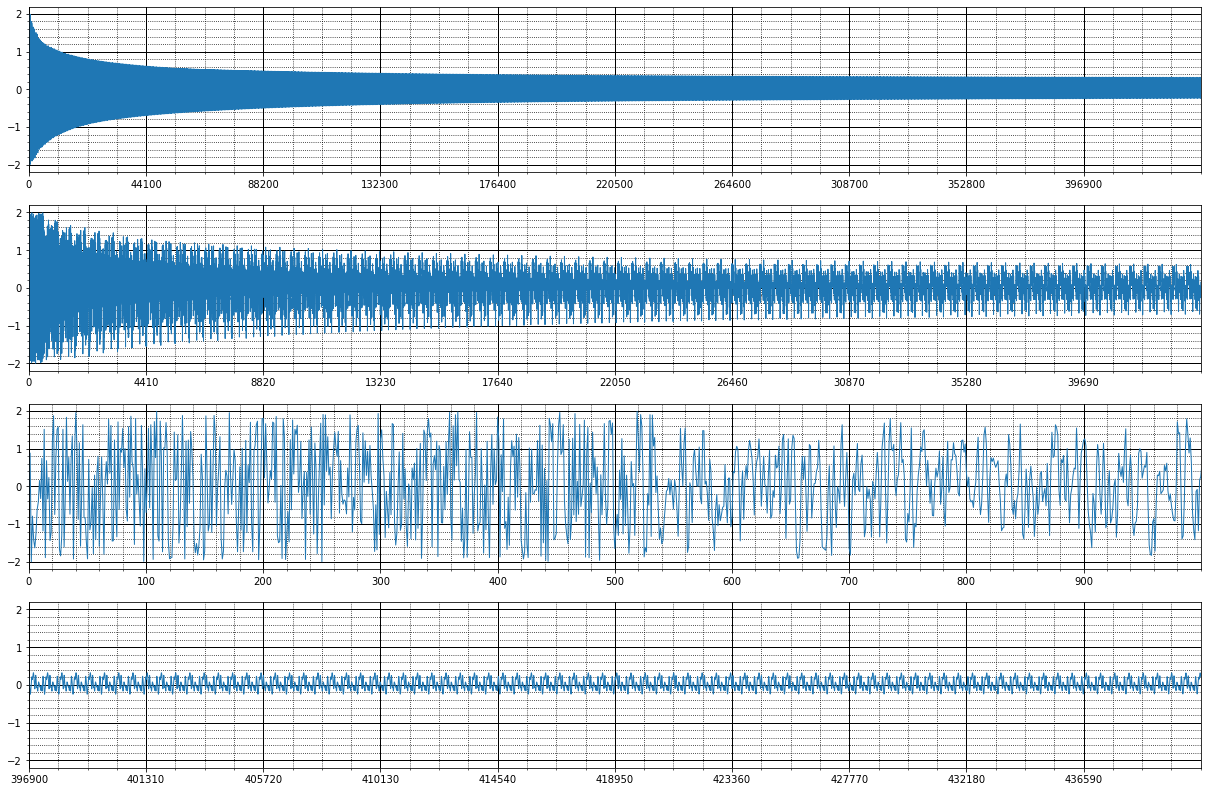

In [29]:
fig, ax = plt.subplots(4, 1, figsize=(21, 14))
for i, xlim in zip(range(3), [(sample_rate * sec, 0), (sample_rate, 0), (1000, 0)]):
    ax[i].plot(gen_wav, linewidth=1)
    ax[i].minorticks_on()
    ax[i].set_xticks(np.arange(0, xlim[0], step=xlim[0] / 10))
    ax[i].set_xlim(xlim[1], xlim[0])
    ax[i].grid(which='major',
        color = 'k', 
        linewidth = 1)
    ax[i].grid(which='minor', 
        color = 'k', 
        linestyle = ':')
ax[3].plot(gen_wav, linewidth=1)
ax[3].minorticks_on()
ax[3].set_xticks(np.arange(0, sample_rate * sec, step=sample_rate / 10))
ax[3].set_xlim(sample_rate * (sec - 1), sample_rate * (sec))
ax[3].grid(which='major',
        color = 'k', 
        linewidth = 1)
ax[3].grid(which='minor', 
        color = 'k', 
        linestyle = ':')
plt.show();
ipd.Audio(gen_wav, rate=sample_rate)

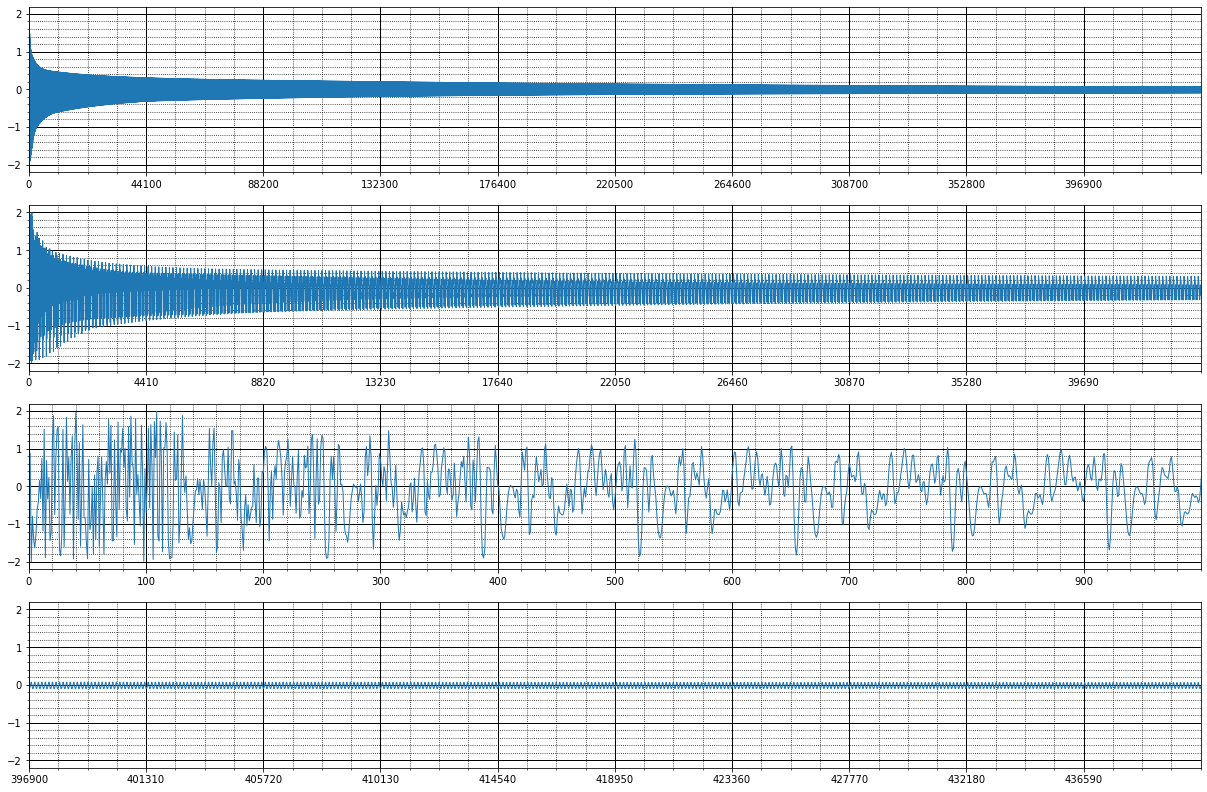

In [30]:
np.random.seed(seed=1)
sample_rate = 44100 
frequency = 329.63
sec = 10
gen_len = sample_rate * sec
noise = (2 * np.random.uniform(-1, 1, int(sample_rate / frequency)))
gen_wav = karplus_strong(noise, gen_len)
fig, ax = plt.subplots(4, 1, figsize=(21, 14))
for i, xlim in zip(range(3), [(sample_rate * sec, 0), (sample_rate, 0), (1000, 0)]):
    ax[i].plot(gen_wav, linewidth=1)
    ax[i].minorticks_on()
    ax[i].set_xticks(np.arange(0, xlim[0], step=xlim[0] / 10))
    ax[i].set_xlim(xlim[1], xlim[0])
    ax[i].grid(which='major',
        color = 'k', 
        linewidth = 1)
    ax[i].grid(which='minor', 
        color = 'k', 
        linestyle = ':')
ax[3].plot(gen_wav, linewidth=1)
ax[3].minorticks_on()
ax[3].set_xticks(np.arange(0, sample_rate * sec, step=sample_rate / 10))
ax[3].set_xlim(sample_rate * (sec - 1), sample_rate * (sec))
ax[3].grid(which='major',
        color = 'k', 
        linewidth = 1)
ax[3].grid(which='minor', 
        color = 'k', 
        linestyle = ':')
plt.show();
ipd.Audio(gen_wav, rate=sample_rate)